# Experiment 2: Do V20 lake fields + some extra surface fields improve our predicitions?

We compare two models:

* `V15`: A model using time variable features + `'cl_v15','lsm_v15','dl_v15','cvl_v15','cvh_v15','anor_v15','isor_v15','slor_v15','sr_v15','lsrh_v15'`
* `V20`: A model using time variable features, the above `*_v15` fields + corresponding V20 corrections for all the 

The correction is obtained by calculating e.g. `cl_V20 - cl_V15`.

---


# A. How do these surface fields change going from V15 to V20?

Before looking at the model results, it is worth having a quick look at how some of the surface field parameters are updated when we go from V15 to V20. See also `A1.V20_vs_V15.ipynb` in this directory.

In [45]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.colors as mc
import matplotlib.colorbar as cb 




def correct_longitude(ds):    
    return ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})


def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize):
    
    """Scatter plot. Bit hacky. """

    try:
        x = ds.longitude
        y = ds.latitude
    except: #different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
    
    
    
def difference_in_surface_fields(file,feature):
    
    
    version = ['v015', 'v020']
    
    ds = [] #Array to hold results
    for v in version:
        path = root+f'climate.{v}/climate.{v}/639l_2/{file}'
        ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': feature}) 
        ds.append(ds_i)
        
        
    
    #Take the difference    
    delta = ds[1] - ds[0] #V20 - V15
    delta = correct_longitude(delta) #long3 ---> long1
    
    return delta
    

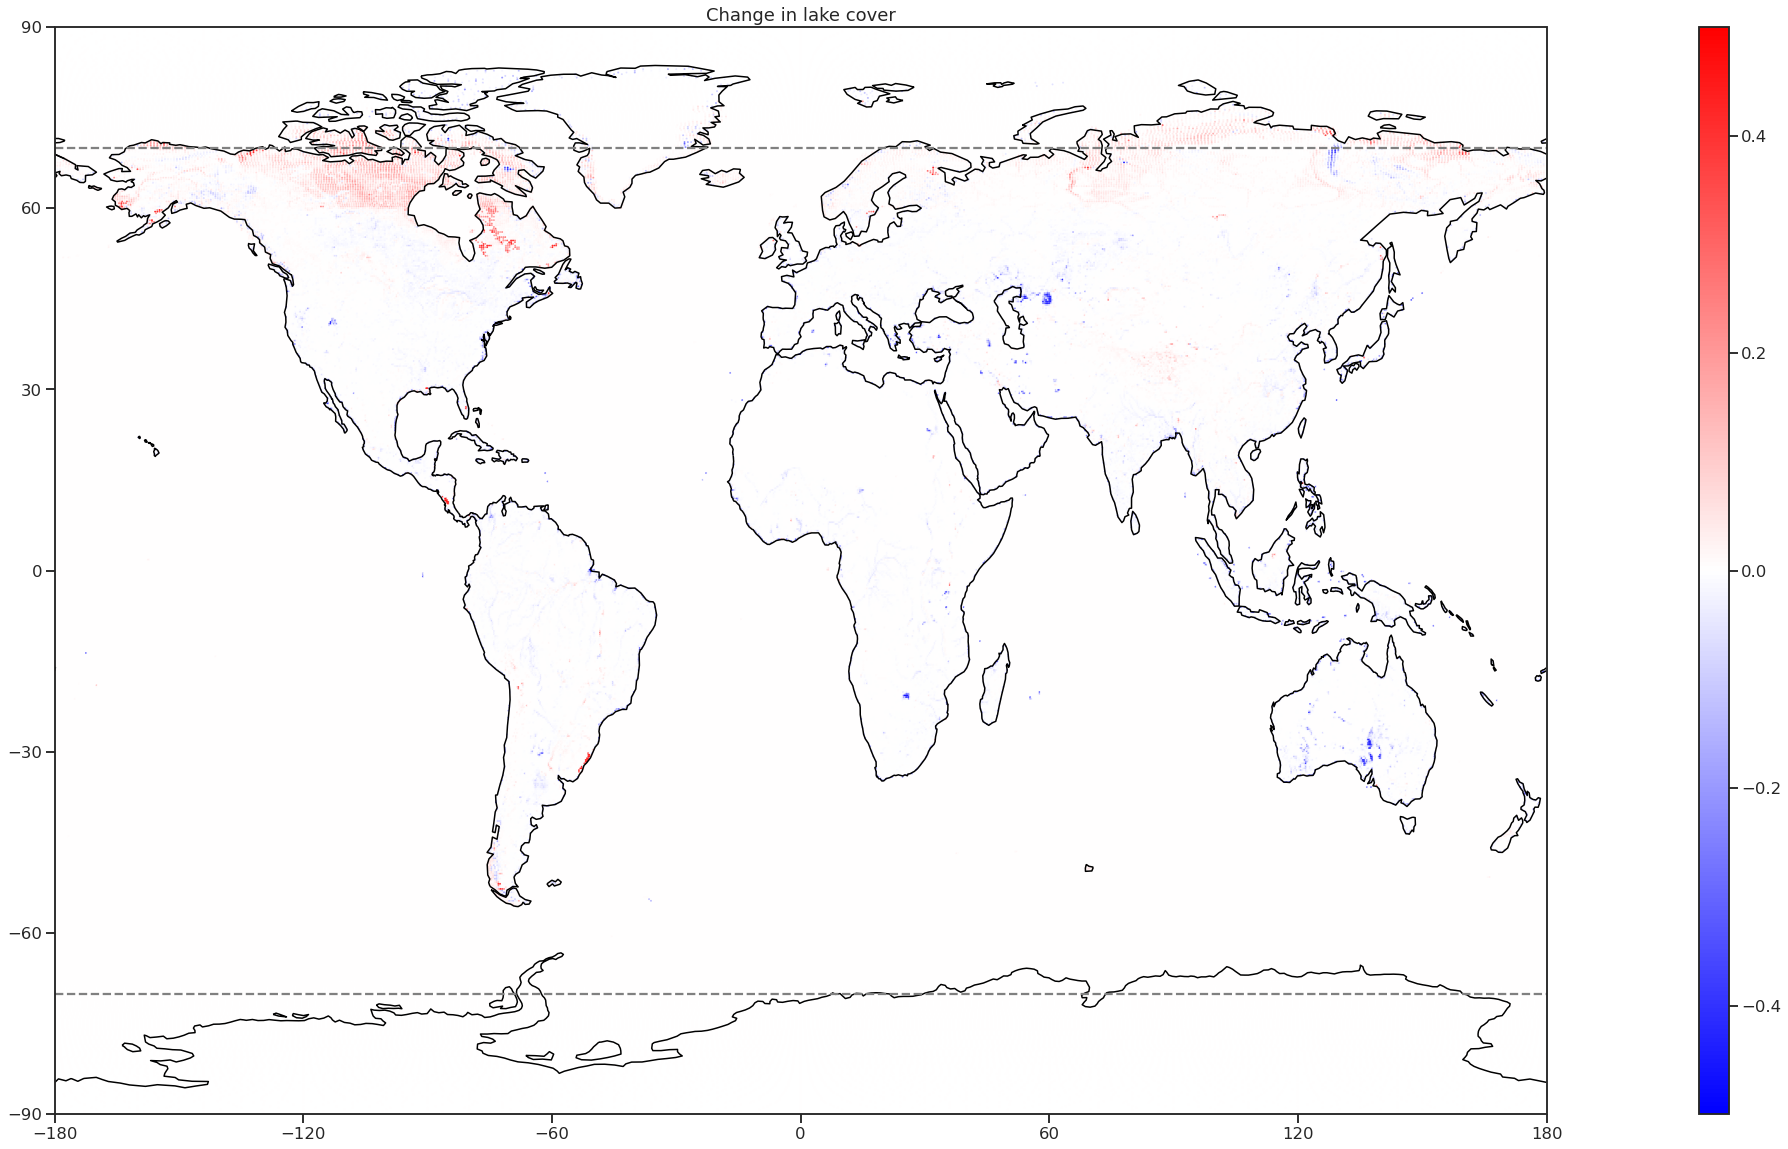

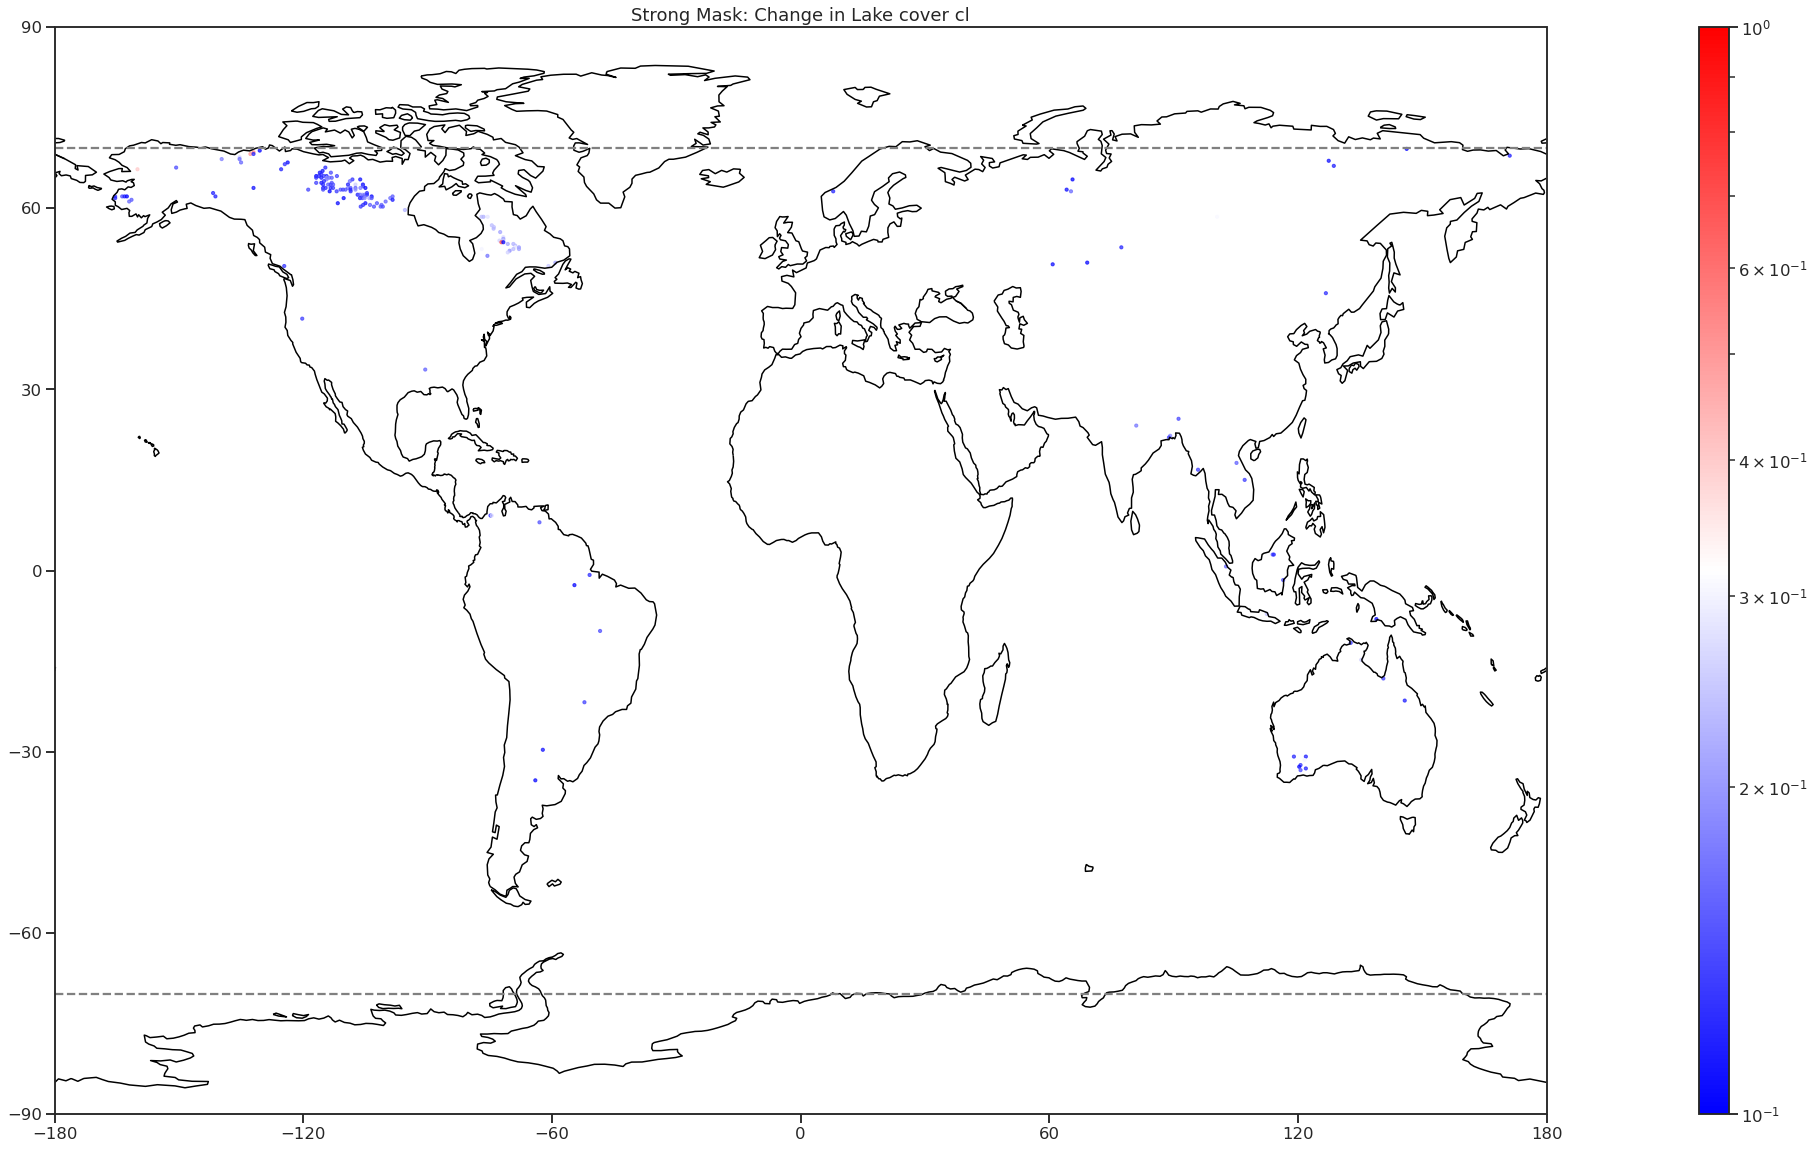

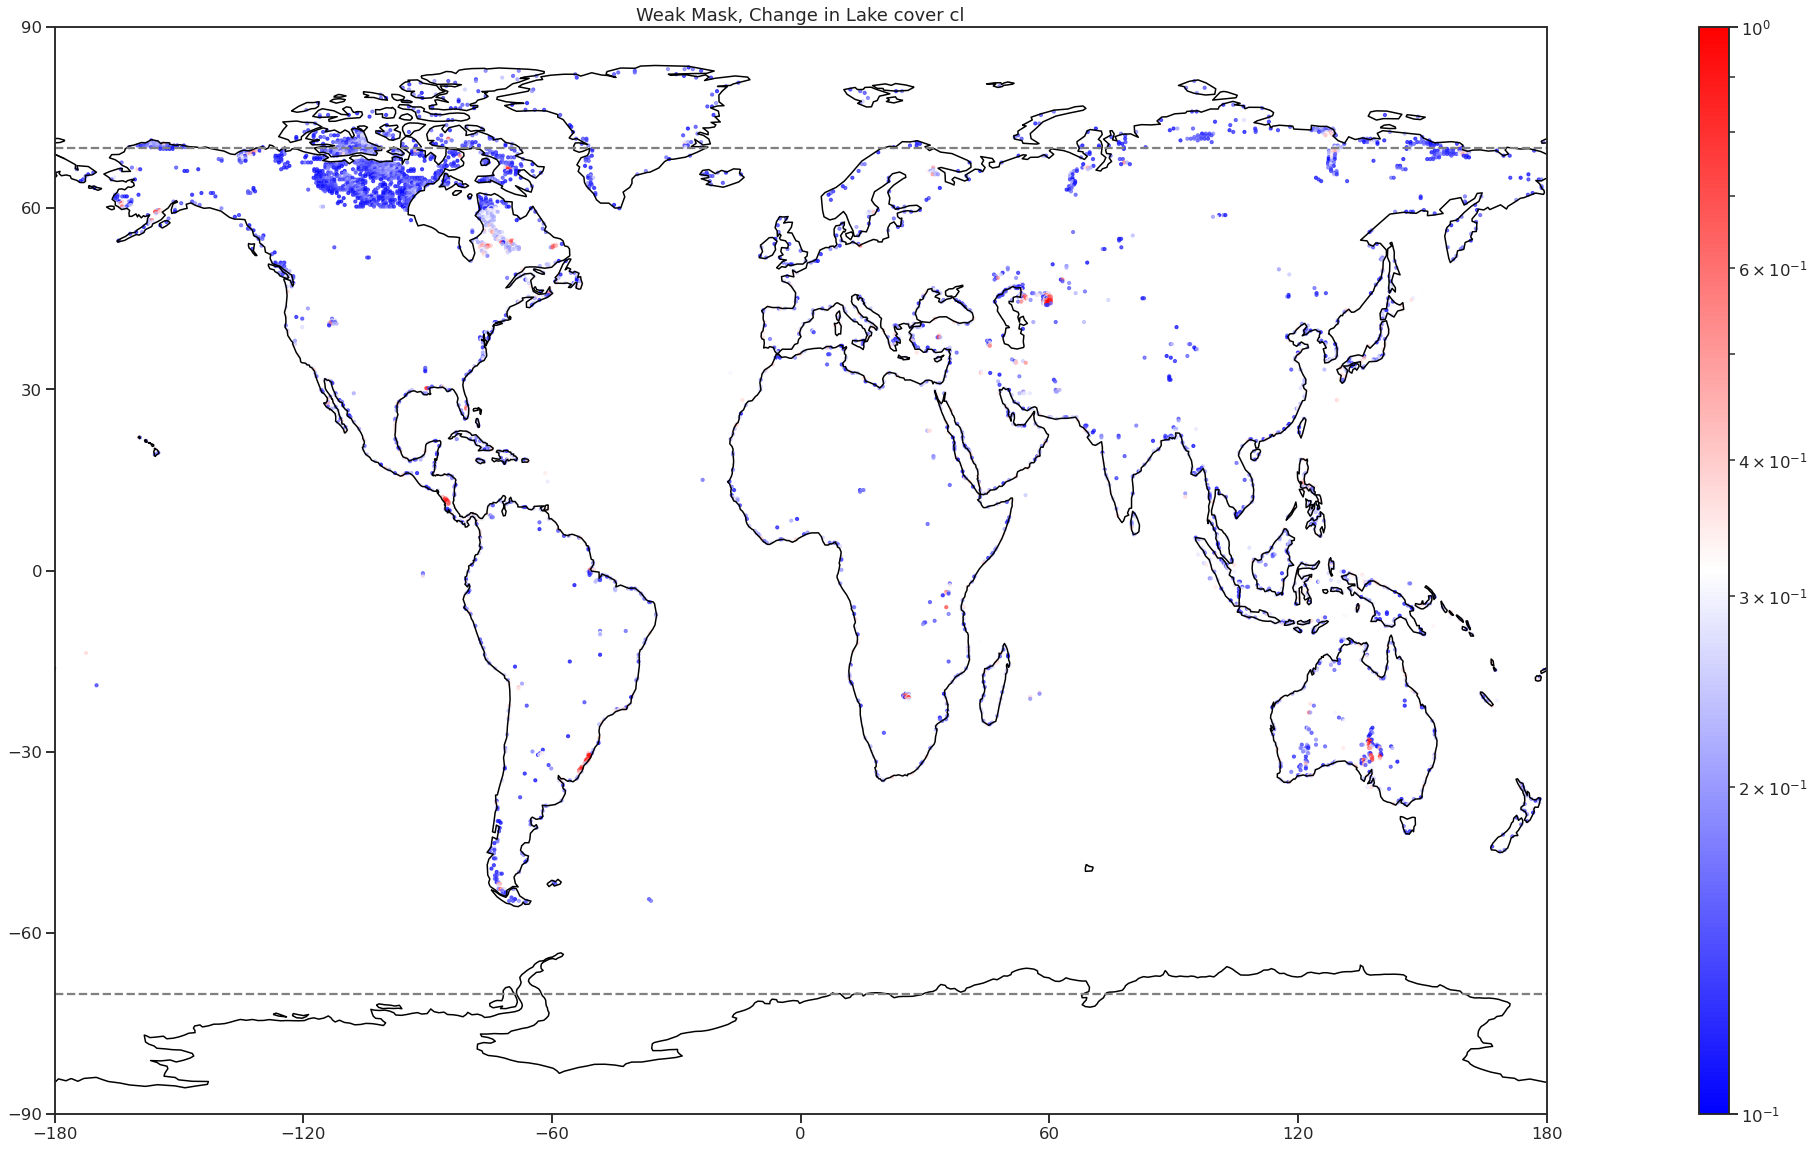

In [46]:

#Get a map of the original V15 lsm. This will only be used to get rid of oceans
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
lsm_path = root+f'climate.v015/climate.v015/639l_2/lsmoro'
ds_lsm= xr.open_dataset(lsm_path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': 'lsm'}) 
ds_lsm = correct_longitude(ds_lsm)
lsm_df = ds_lsm.to_dataframe().reset_index() #Make it a df
all_fields = lsm_df.copy()



#Now look at all the features which are changing
changing_features = ['cl','lsm','dl','cvl','cvh']
changing_files = ['clake','lsmoro','lakedl','sfc','sfc']


for i in range(len(changing_features)): 
    file = changing_files[i]
    feature=changing_features[i]
    delta = difference_in_surface_fields(file,feature)
    
    all_fields[f'delta_{feature}'] = delta[feature].values
    
    
#We can define some masks based on how we want to filter the data
strong_mask = all_fields.query('abs(delta_cl) > 0.1 & abs(delta_lsm) > 0.0 & abs(delta_dl)>0.0 & abs(delta_cvl) > 0.0 & abs(delta_cvh) > 0.0')
weak_mask = all_fields.query('abs(delta_cl) > 0.1')

plot_map(all_fields,'delta_cl',vmin=-0.5,vmax=+0.5,cmap=plt.cm.bwr,logscale=False,title='Change in lake cover',limits=limits,markersize=1)
plot_map(strong_mask,'delta_cl',vmin=1e-1,vmax=+1,cmap=plt.cm.bwr,logscale=True,title=f'Strong Mask: Change in Lake cover cl',limits=None,markersize=10) #What does this mask look like?
plot_map(weak_mask,'delta_cl',vmin=1e-1,vmax=+1,cmap=plt.cm.bwr,logscale=True,title=f'Weak Mask, Change in Lake cover cl',limits=None,markersize=10) #What does this mask look like?

We can see that the siginificant modifications to the lake cover happen in a few key areas.


---

# B. How does this extra information influence the model?


Ok we now have seen how the features are changing. If we pass this extra information to the model, does it improve our predictions?

In [75]:
import pandas as pd
import json
import numpy as np

def load_predictions(path):

    df = pd.read_pickle(path+'predictions.pkl')
    df['model_error'] = df.MODIS_LST - df.predictions
    df['absolute_model_error'] = abs(df.MODIS_LST - df.predictions)

    
    return df

def plot_training_history(path,logscale,jump_n_epochs,upper_limit):
    
    print('Path =', path)
    
    with open(path+'meta.txt') as f:
        lines = f.readlines()
        print(*lines)
        #print( [row for row in lines])
    
    
    
    
    with open(path+'history.json') as f:
        d = json.load(f)
        i = jump_n_epochs
        training_loss = d['loss'][i:]
        epochs = np.arange(len(training_loss))
        
        
        idxmin = np.argmin(training_loss)
        

        fig = plt.figure(figsize=(10, 10))
        plt.plot(epochs,training_loss,label='training loss')
        plt.scatter(epochs[idxmin],training_loss[idxmin])

        try:
            validation_loss = d['val_loss'][i:]
            idxmin = np.argmin(validation_loss)
            plt.plot(epochs,validation_loss, label='validation loss')
            plt.scatter(epochs[idxmin],validation_loss[idxmin])
            print('Minimum validation loss:',validation_loss[idxmin])

        except:
            pass
        plt.legend()
        
        if logscale:
            plt.yscale('log')
            
            
        plt.ylim(0.01,upper_limit)
            




Path = /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_5f6e838711334702b2fe6d9429c1a6ae/
input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/all_months_V3.h5
 train_condition: 2019-01-01 00:00:00
 test_condition: 2020-01-01 00:00:00
 epochs: 100
 batch_size: 1024
 features: ['sp', 'msl', 'u10', 'v10', 't2m', 'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m', 'fal', 'skt', 'cl_v15', 'lsm_v15', 'dl_v15', 'cvl_v15', 'cvh_v15', 'anor_v15', 'isor_v15', 'slor_v15', 'sr_v15', 'lsrh_v15']
 optimizer: adam

Minimum validation loss: 0.043332479894161224
Path = /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_1bac10ad60514426934b4709e78ddfb7/
input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/all_months_V3.h5
 train_condition: 2019-01-01 00:00:00
 test_condition: 2020-01-01 00:00:00
 

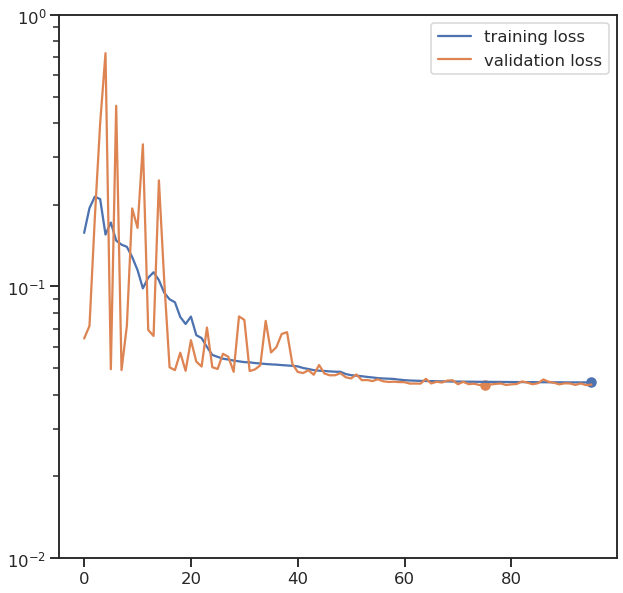

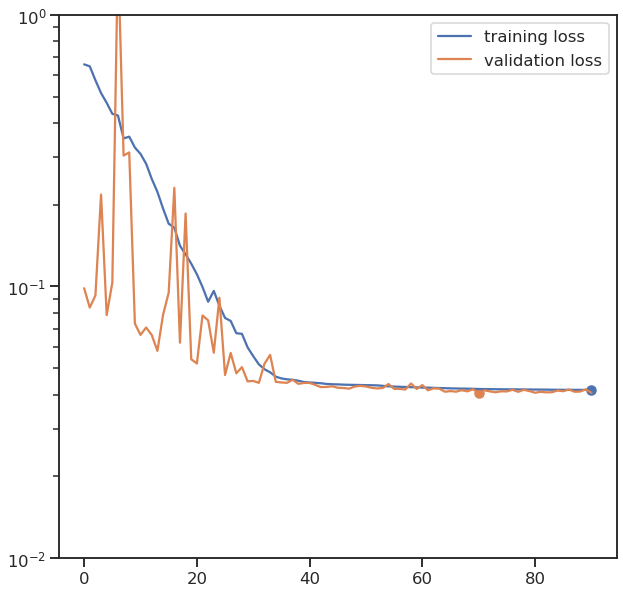

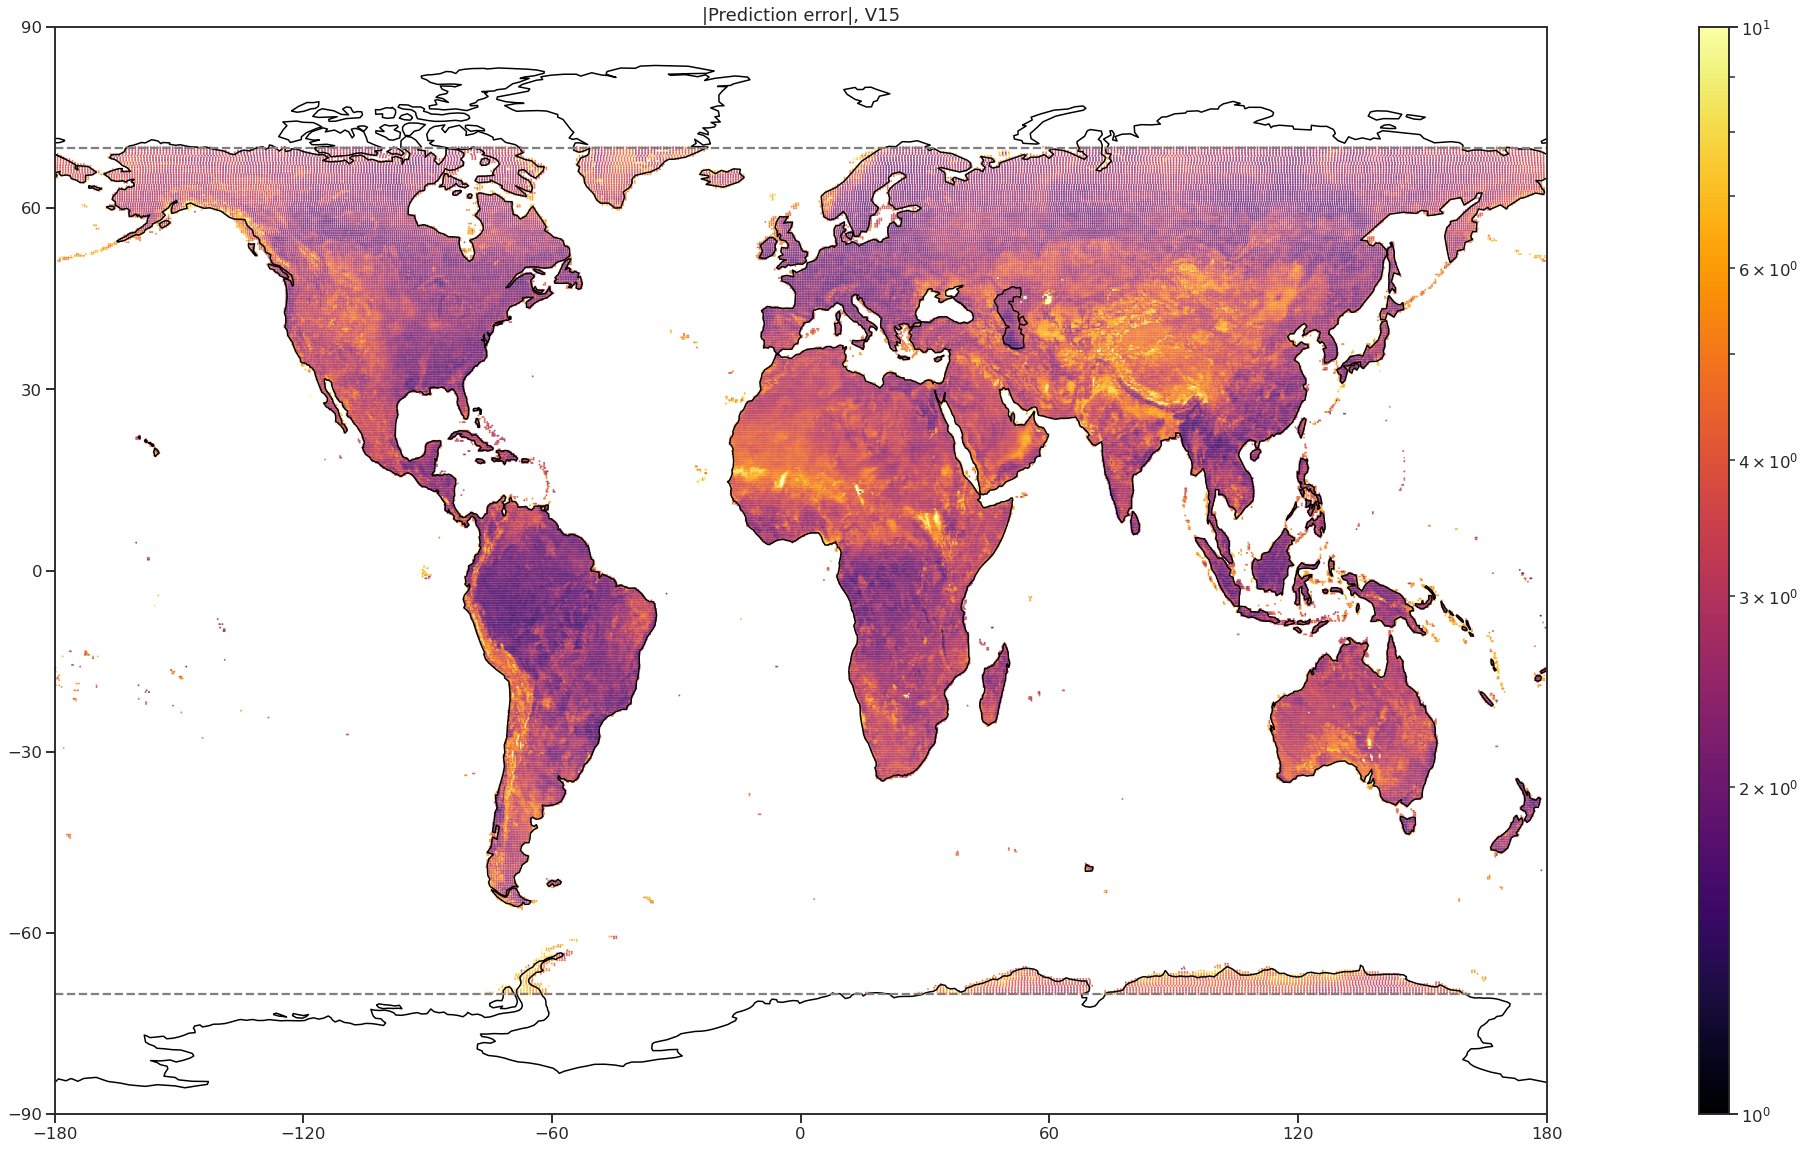

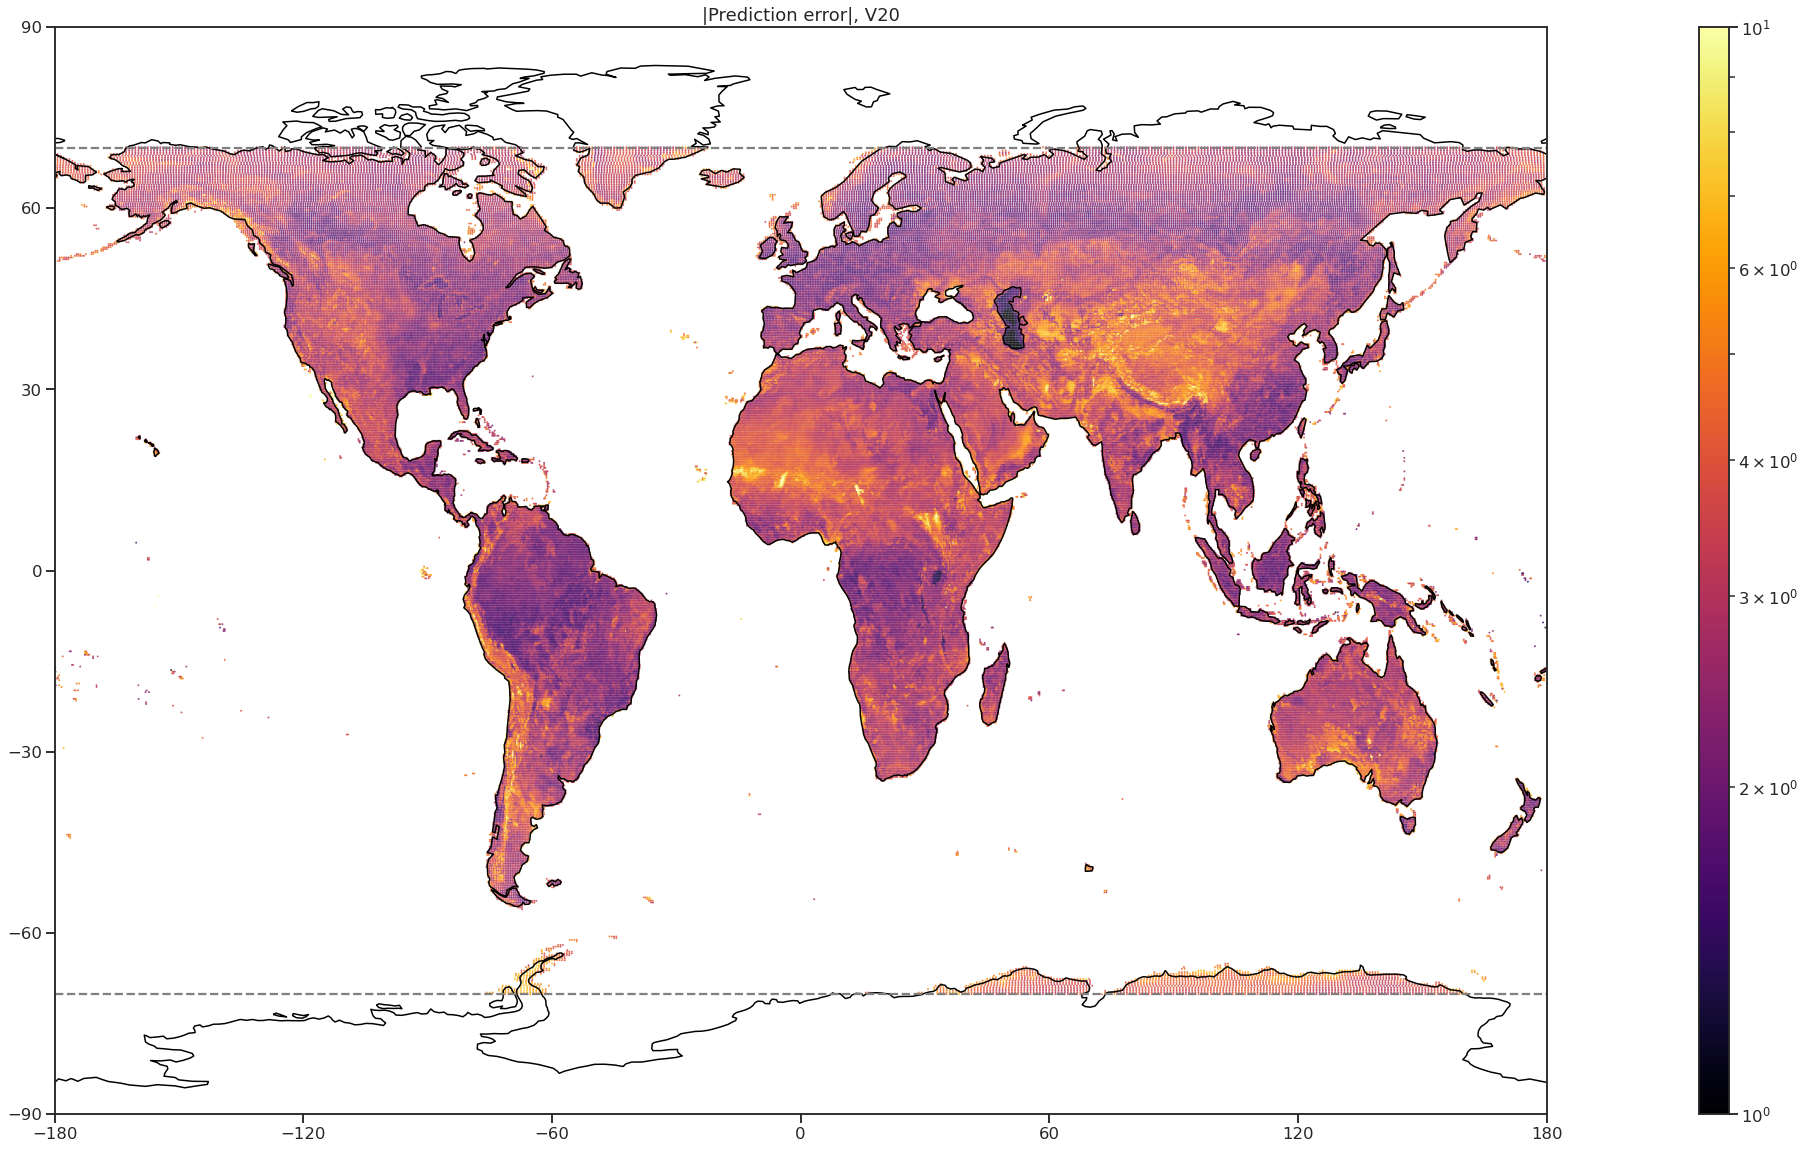

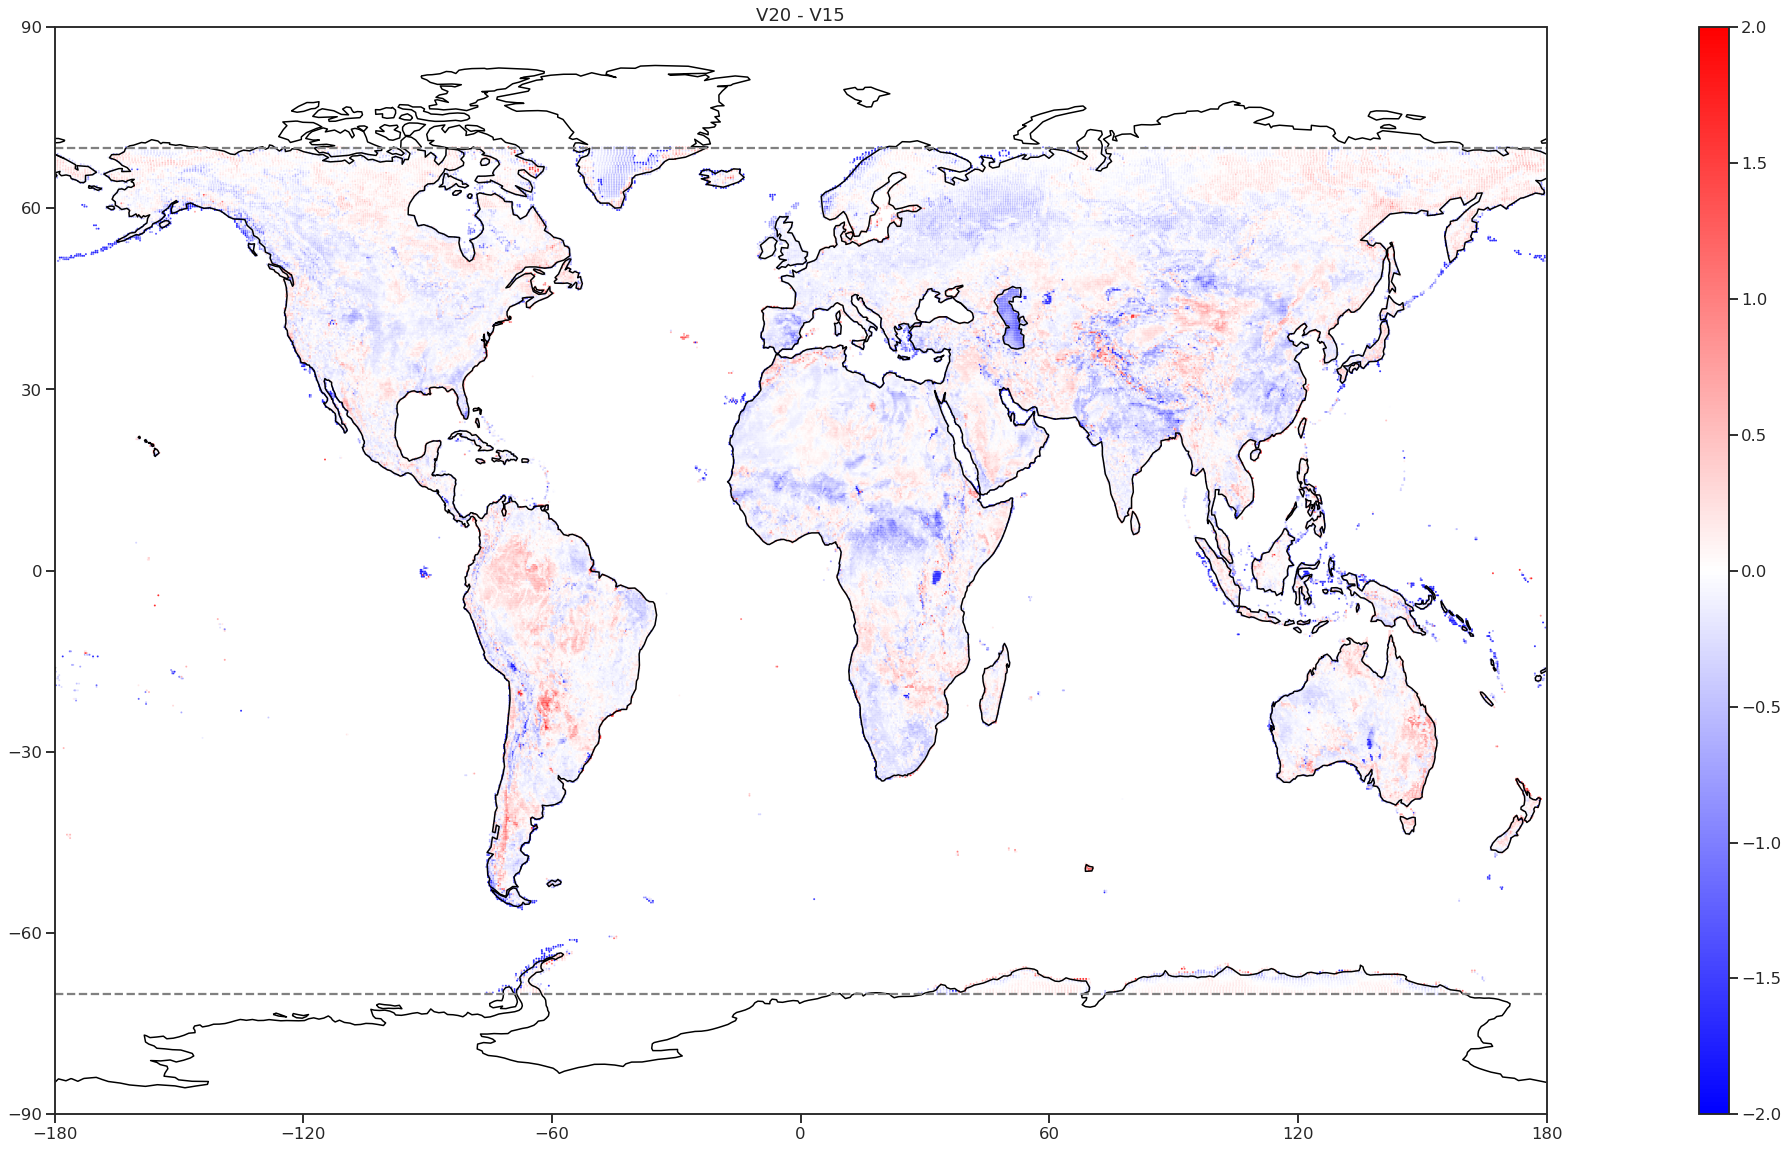

In [85]:
models_root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/'

modelV15 = models_root+'ML_5f6e838711334702b2fe6d9429c1a6ae/'#v15, batchsize 1024, LR 3e-4
modelV20 = models_root+'ML_1bac10ad60514426934b4709e78ddfb7/' #v20. batchsize 1024, LR 3e-4. 2 hidden layers


#modelV20 = models_root+'ML_792ce8ee7476412face8f0c36da82287/' #v20, batchsize 1024, LR 3e-4. OLD
# ML_d360eb7b7d0a4a45ad6eb421f1994552. v15, batchsize 10,000, LR 3e-4
#ML_6102888f3be74a08ba1324385b763f16 v20, batchsize 10,000, LR 3e-4

cmap = plt.cm.inferno
logscale = True #None
vmin = 1
vmax = 10


#Process 
V15 = load_predictions(modelV15) #Load data
V15_grouped = V15.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() #averagee predictions over the year


V20 = load_predictions(modelV20)
V20_grouped = V20.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
    
    
    
#Plot training history for interest
plot_training_history(modelV15,logscale=True,jump_n_epochs=1,upper_limit = 1) 
plot_training_history(modelV20,logscale=True,jump_n_epochs=1,upper_limit = 1)
    
    
#Plot the map of the prediction error    
plot_map(V15_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V15',limits=None,markersize=1)
plot_map(V20_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V20',limits=None,markersize=1)

    
#Create a new df that will just hold the differences, and plot it    
data = {'latitude_ERA':   V20_grouped.latitude_ERA, 
        'longitude_ERA':  V20_grouped.longitude_ERA,
        'MODIS_LST':      V20_grouped.MODIS_LST,
        'V15_prediction': V15_grouped.predictions,
        'V20_prediction': V20_grouped.predictions,
        'V15_error':      V15_grouped.absolute_model_error,
        'V20_error':      V20_grouped.absolute_model_error,
        'delta':          V20_grouped.absolute_model_error - V15_grouped.absolute_model_error}
df_delta = pd.DataFrame(data)    
plot_map(df_delta,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,logscale=False,title='V20 - V15',limits=None,markersize=1)


# B1 Apply a mask




From this map it is hard to disentangle regions of improvement over the inherent variability due to the stochasticity of training the model.

What we can do is **apply a mask to isolate just those regions where cl has been changed appreciably**

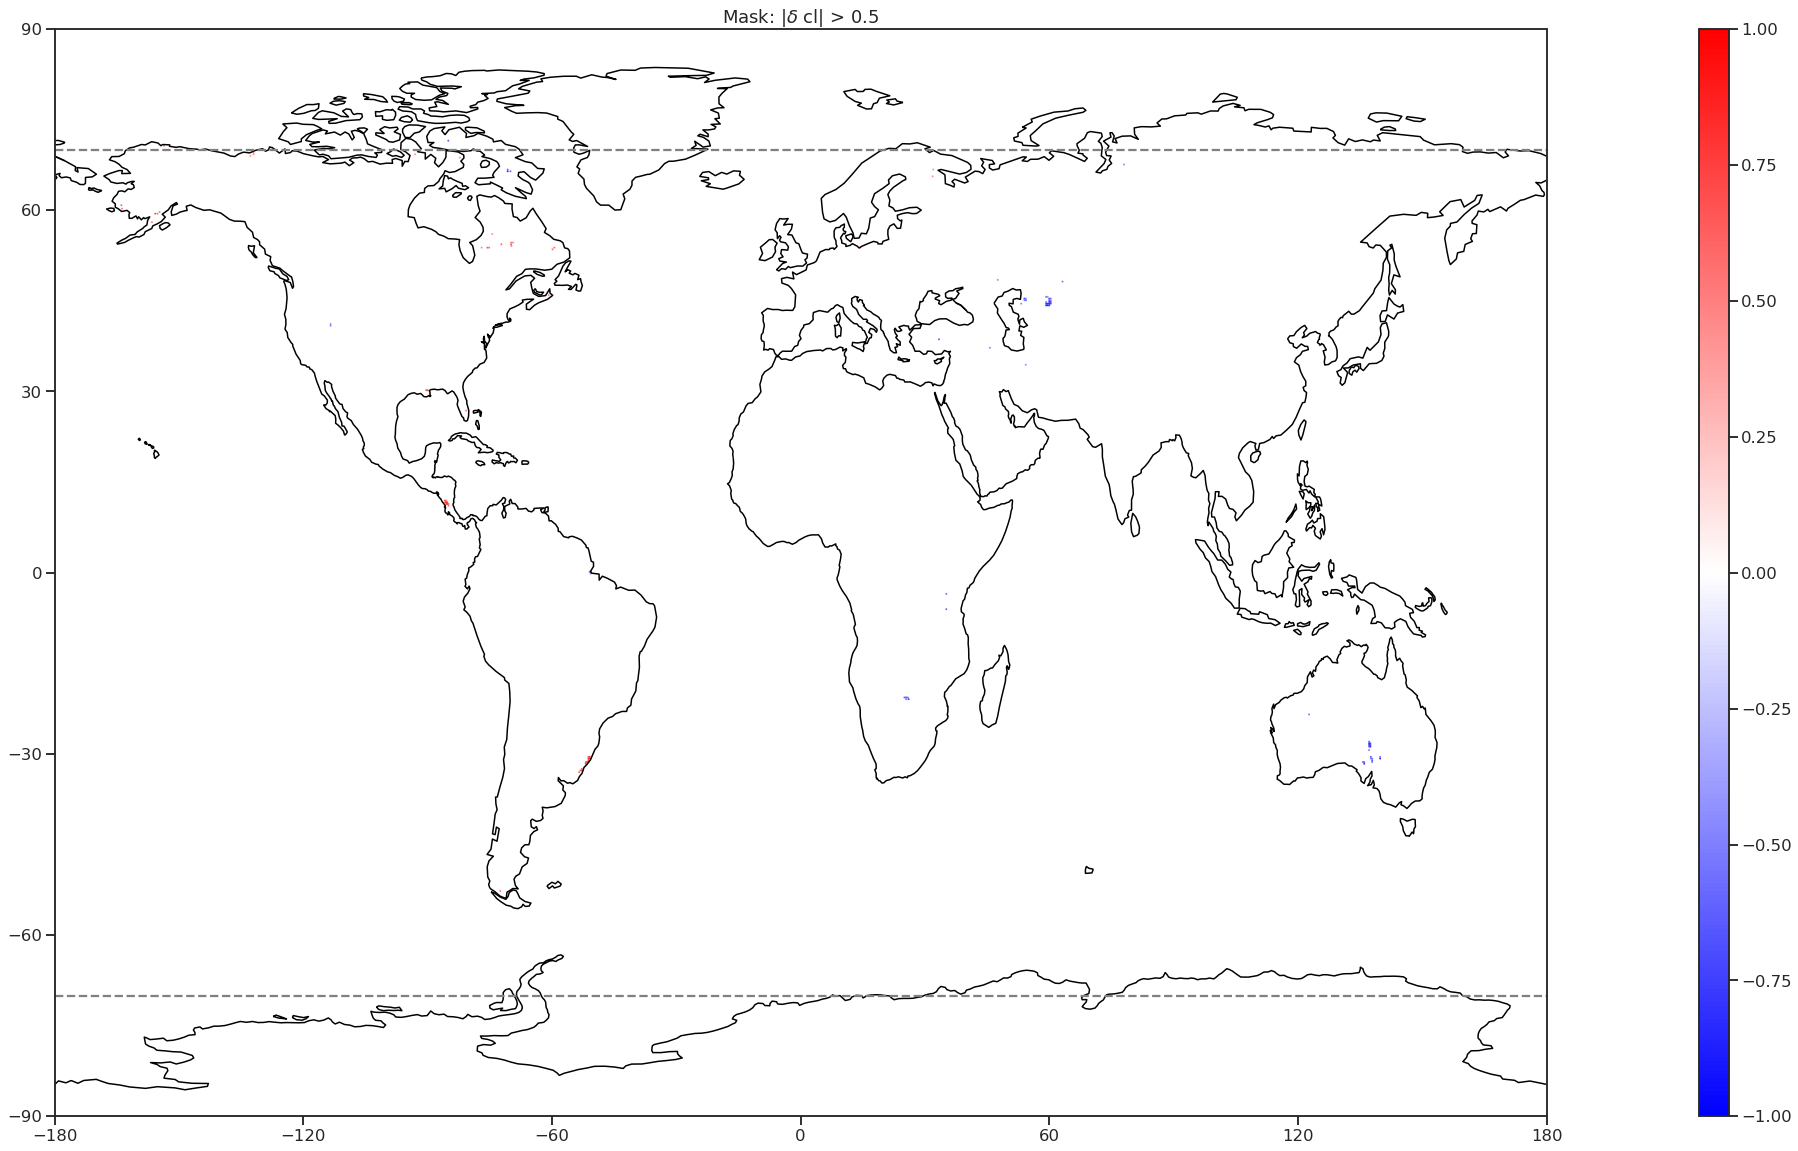

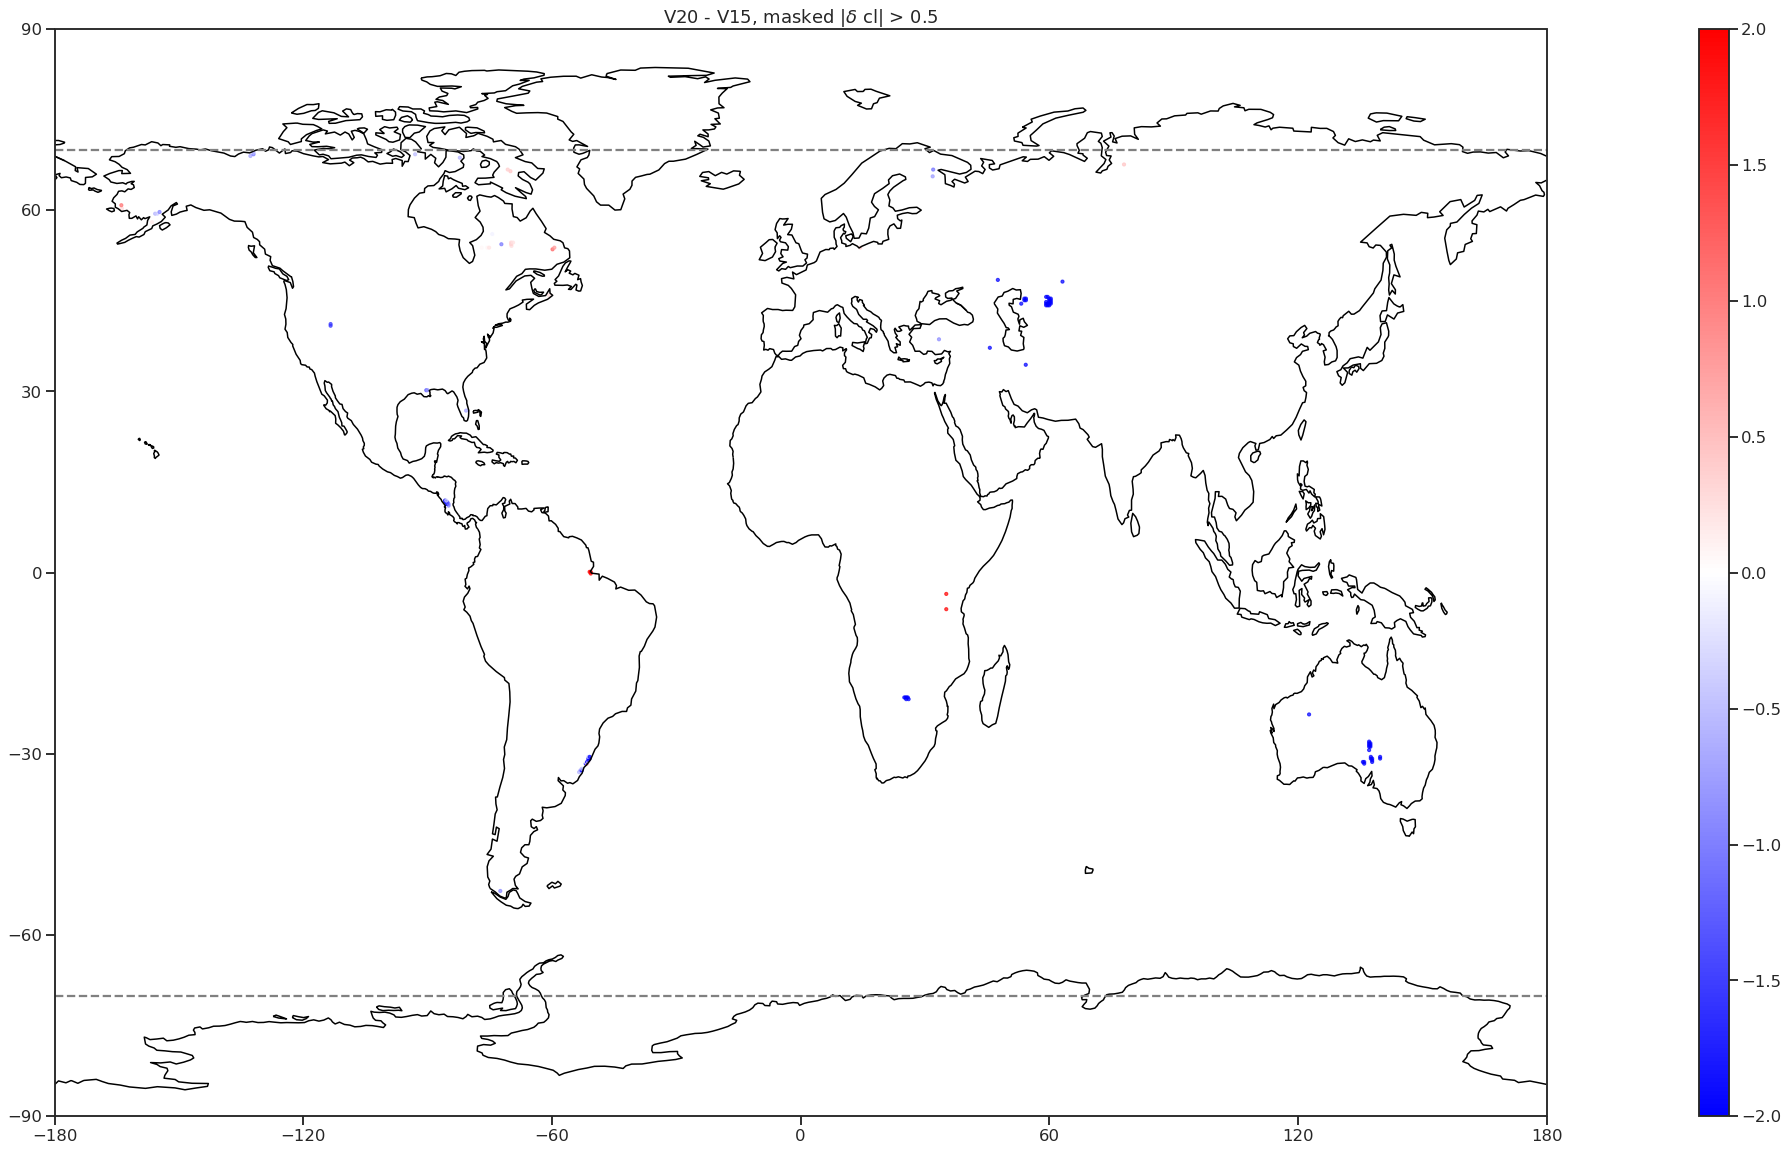

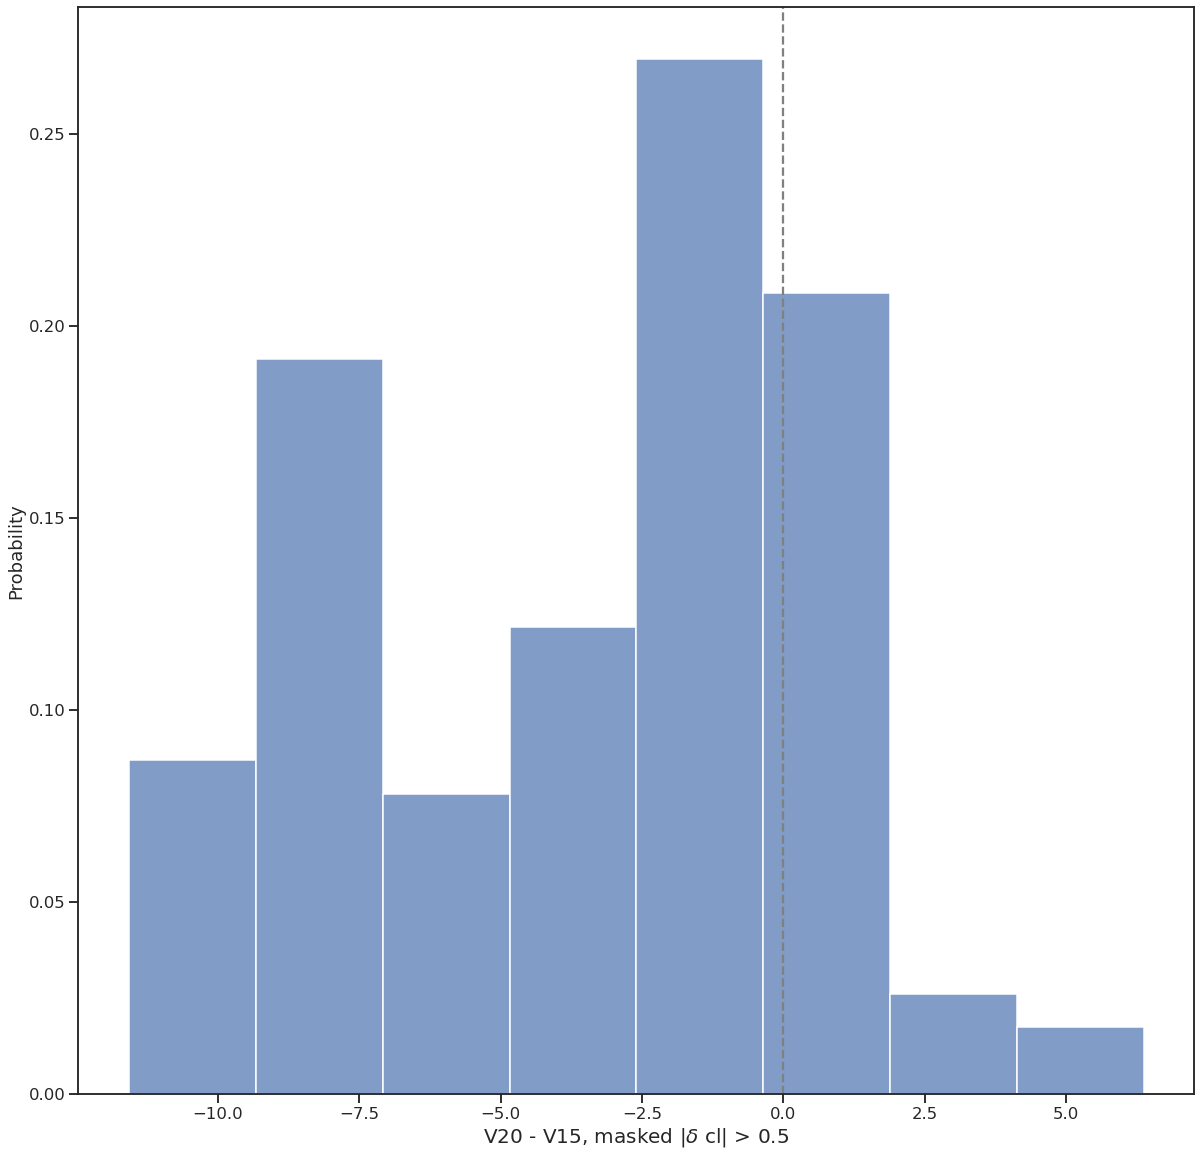

Mean Improvement = -3.479932
Num samples = 115
Max improvement =  -11.56693


In [90]:

#Create a mask and plot it
#mask = delta.to_dataframe().reset_index() #delta is V20 cl - V15 cl that we defined in section A

p = 0.5 # cutoff paramter
mask = all_fields.query(f'abs(delta_cl) > {p}') #all_fields is V20 - V15 that we defined in section A
#mask = mask[abs(mask.cl) > p] #Only get the points where cl changed by > 0.3. What is a reasonable value for this variable?
plot_map(mask,'delta_cl',vmin=-1,vmax=1,cmap=plt.cm.bwr,logscale=False,title=f'Mask: |${{\delta}}$ cl| > {p}',limits=None,markersize=1) #What does this mask look like?

#Apply mask to df_delta
df_delta_masked = pd.merge(df_delta,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude'])
plot_map(df_delta_masked,'delta',
         vmin=-2,vmax=+2,
         cmap=plt.cm.bwr,
         logscale=False,
         title=f'V20 - V15, masked |${{\delta}}$ cl| > {p}',
         limits=None,
         markersize=10)


#Plot distribution of improvements
import seaborn as sns


#Setup plot env
h,w = 20,20
sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )
#Figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
sns.histplot(df_delta_masked['delta'], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0')


# Config
ax1.set_xlabel(f'V20 - V15, masked |${{\delta}}$ cl| > {p}', fontsize = 20)

ax1.axvline(0,c='0.5', linestyle='--')
plt.show()



#Surface some numbers

print('Mean Improvement =', df_delta_masked.delta.mean())
print ('Num samples =',  len(df_delta_masked))
print ('Max improvement = ',df_delta_masked.delta.min() )



In [12]:
display(df_delta_masked.sort_values(by=['delta'],ascending=False).head(20))

latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
865      -3.512879      35.156250  301.797272      301.215057      312.696106   
792      -6.042153      35.156250  305.171234      302.833801      316.468719   
857      -3.793910      34.875000  305.867157      306.725952      314.053711   
2788     54.379367     -72.187500  270.896057      273.900299      261.777618   
1023      0.140515     -50.625000  299.526062      302.756317      307.929779   
1015     -0.140515     -50.625000  300.542664      303.356567      308.488953   
1022      0.140515     -50.906250  301.339539      302.698303      308.641052   
1893     29.367672      53.750000  306.283661      306.881317      312.697388   
1375     13.067912      14.343750  300.484894      303.243561      307.683319   
1902     29.648702      53.437500  307.886749      307.086700      313.904602   
665      -9.976578     -42.187500  303.127777      307.062805      311.149597   
1892     29.367672      52.812500  306.122681      308.015808      312.314026   
1959     31.615914      88.960000  284.477783      285.991425      278.293304   
2193     38.079612      45.333333  291.615021      291.466309      297.561188   
2331     41.451975    -112.320000  295.985901      297.805573      302.314240   
1750     24.028095      69.000000  313.644440      303.138489      299.991058   
1716     23.185004      31.200000  311.227936      315.518494      318.719330   
888      -2.950819     -41.343750  303.930237      307.192230      310.319519   
1142      5.199062      -9.281250  298.925903      302.088684      305.156342   
2298     40.889915    -111.960000  297.192566      298.433563      302.780609   

      V15_error  V20_error     delta  values   step  surface   latitude  \
865    1.942433  10.898833  8.956400  286525 0 days      0.0  -3.512879   
792    2.764847  11.297493  8.532646  298045 0 days      0.0  -6.042153   
857    2.534619   8.192524  5.657906  287804 0 days      0.0  -3.793910   
2788   4.131008   9.252876  5.121868   52171 0 days      0.0  54.379367   
1023   3.324917   8.403712  5.078795  270860 0 days      0.0   0.140515   
1015   2.901267   7.946290  5.045022  272140 0 days      0.0  -0.140515   
1022   2.445054   7.301496  4.856441  270859 0 days      0.0   0.140515   
1893   2.068503   6.413722  4.345218  139475 0 days      0.0  29.367672   
1375   3.012808   7.198430  4.185622  210931 0 days      0.0  13.067912   
1902   2.056443   6.018442  3.961999  138322 0 days      0.0  29.648702   
665    4.140851   8.056483  3.915632  316970 0 days      0.0  -9.976578   
1892   2.556520   6.200523  3.644003  139472 0 days      0.0  29.367672   
1959   3.078899   6.570055  3.491156  130500 0 days      0.0  31.615914   
2193   2.629681   6.046658  3.416977  105113 0 days      0.0  38.079612   
2331   3.037817   6.431297  3.393481   93521 0 days      0.0  41.451975   
1750  10.514669  13.653387  3.138718  162045 0 days      0.0  24.028095   
1716   4.383407   7.505180  3.121773  165519 0 days      0.0  23.185004   
888    3.418516   6.417758  2.999242  284973 0 days      0.0  -2.950819   
1142   3.232810   6.230427  2.997617  247967 0 days      0.0   5.199062   
2298   2.939669   5.819212  2.879543   95522 0 days      0.0  40.889915   

       longitude        cl  
865    35.156250 -0.638541  
792    35.156250 -0.727888  
857    34.875000 -0.402907  
2788  -72.187500  0.731721  
1023  -50.625000 -0.603153  
1015  -50.625000 -0.588097  
1022  -50.906250 -0.604843  
1893   53.750000 -0.265700  
1375   14.343750 -0.163499  
1902   53.437500 -0.348912  
665   -42.187500 -0.154305  
1892   52.812500 -0.222259  
1959   88.960000  0.116714  
2193   45.333333 -0.267091  
2331 -112.320000 -0.267667  
1750   69.000000  0.121381  
1716   31.200000 -0.371459  
888   -41.343750 -0.322522  
1142   -9.281250 -0.391908  
2298 -111.960000 -0.222562

Note:
* Blues = good. This means that the error in V15 is greater than the error in V20.